In [2]:
pip install pandas numpy scikit-learn geopandas shapely fiona pyproj rtree xgboost


  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached rtree-1.4.1-py3-none-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.9 MB/s eta 0:00:00
Using cached rtree-1.4.1-py3-none-macosx_11_0_arm64.whl (436 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl (11 kB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [geopandas]/9 [geopandas]ins]


In [3]:
pip install dbfread

  Using cached dbfread-2.0.7-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached dbfread-2.0.7-py2.py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.


Loaded 227428 rows.
Matched: 181871 rows to boroughs.
Original #categories: 251
Grouped into: 31 categories (incl. 'Other').
Context rows: 835
Evaluation Metrics
Train MSE: 1.8607569905943023e-06
Test MSE: 0.0015568482960376347
Test RMSE: 0.03945691696062472
MAE: 0.017317713880758305
Overall R^2: 0.6717069112003783
Mean Cosine Similarity: 0.905224
Top 5 best R^2 values:
Airport                 0.813615
Subway                  0.758200
Bar                     0.551015
Clothing Store          0.465242
Gym / Fitness Center    0.348106
dtype: float64
 Worst R^2 values:
Building                    -0.114803
Pizza Place                 -0.203276
Bus Station                 -0.229058
College Academic Building   -0.623843
Bakery                      -0.632035
dtype: float64


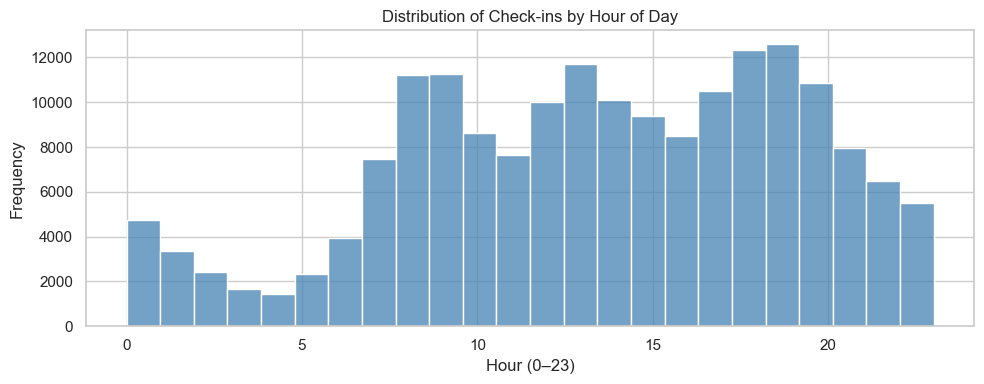

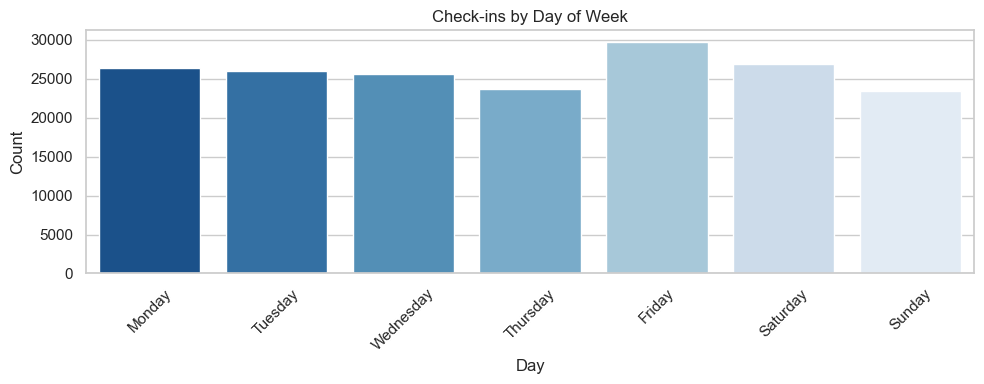

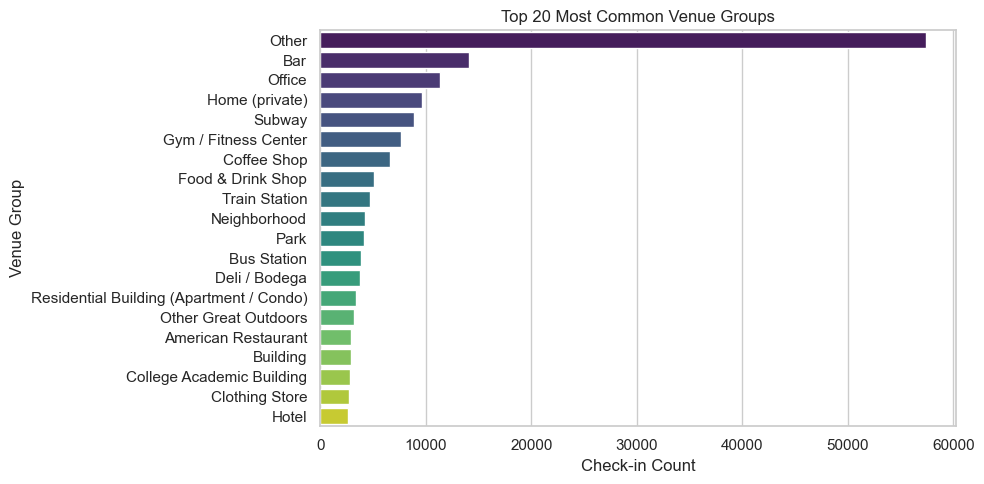

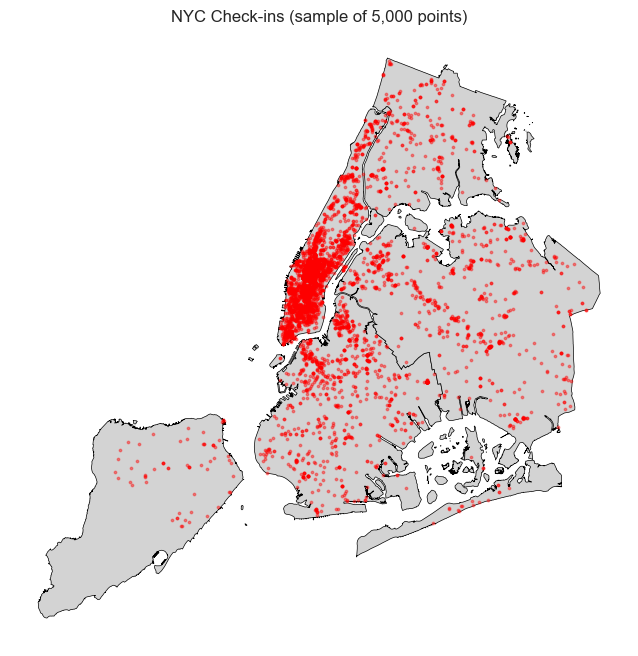

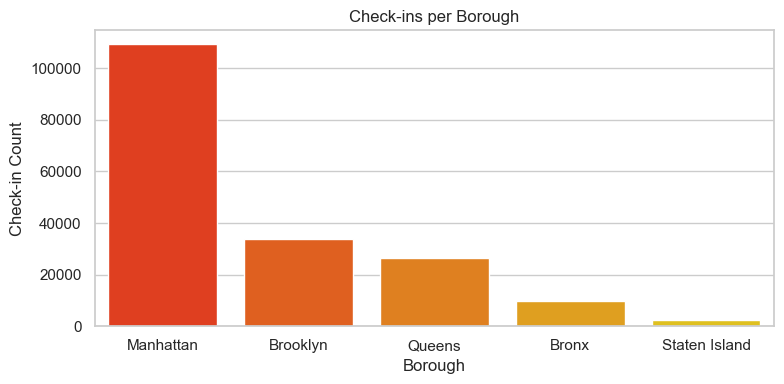


Top 15 Predicted Venue Categories for Manhattan on Friday at 21(this is army time!):
Other                                       0.218744
Bar                                         0.157940
American Restaurant                         0.056272
Movie Theater                               0.042934
Italian Restaurant                          0.037094
Subway                                      0.036433
Mexican Restaurant                          0.033306
Pizza Place                                 0.029748
Home (private)                              0.029045
Food & Drink Shop                           0.027162
Train Station                               0.025310
Residential Building (Apartment / Condo)    0.024926
Office                                      0.023955
Gym / Fitness Center                        0.022000
Coffee Shop                                 0.021868
dtype: float32


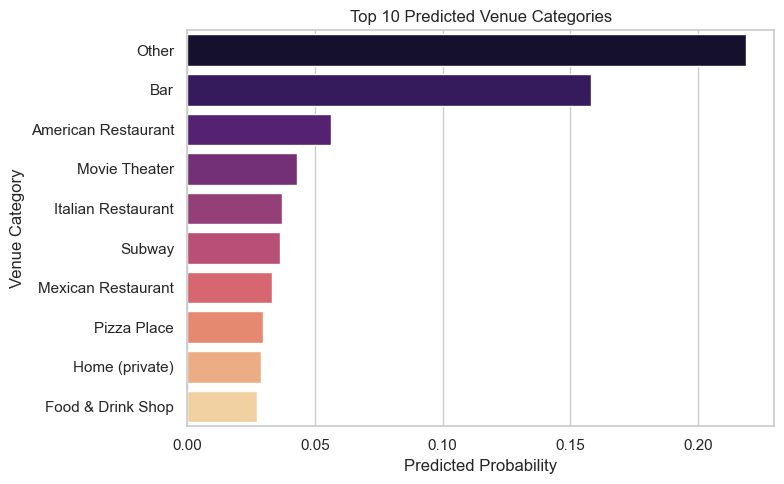

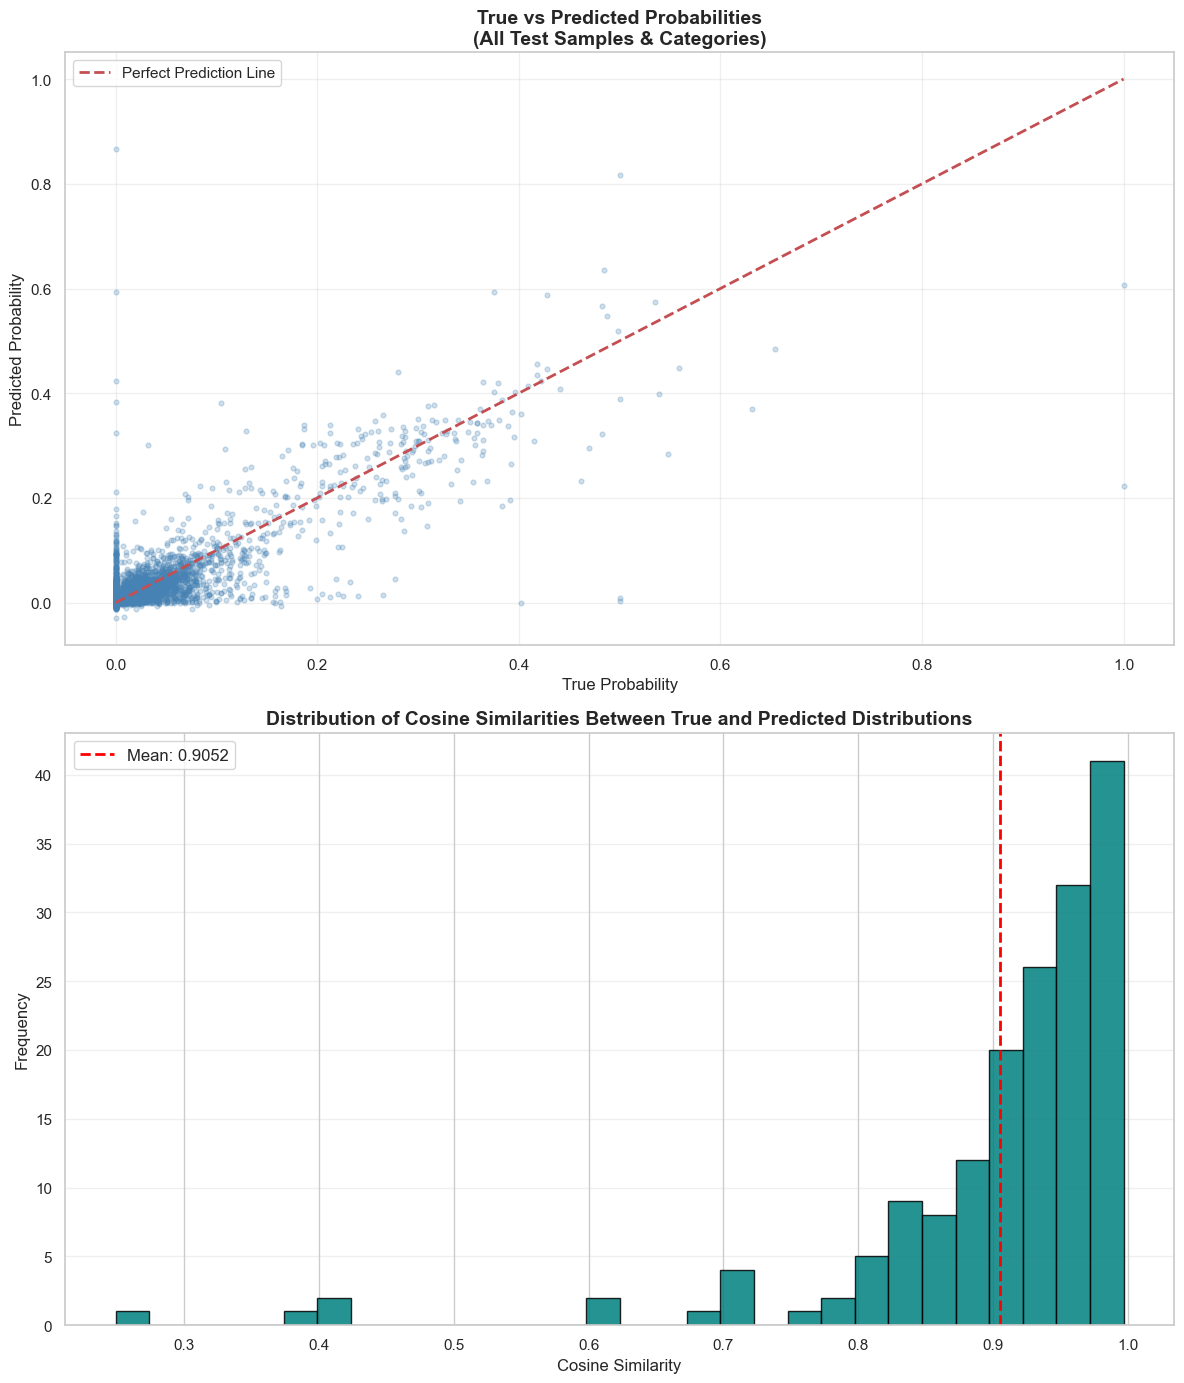

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from xgboost import XGBRegressor

sns.set(style="whitegrid")


# 1. LOAD RAW DATA

def load_raw_data():
    fp = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(fp, encoding="ISO-8859-1")
    print(f"Loaded {len(df)} rows.")
    return df


# 2. NORMALIZE TIME


def normalize_times(df):
    df = df.copy()

    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"],
        utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )

    df = df.dropna(subset=["UTC_Time"])

    # NOTE: timezoneOffset is in minutes; dataset appears to be local = UTC + offset
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m") #basically adds the timezone offset to the UTC time 
    #to get local time or eastern timezone
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour

    return df


# 3. ATTACH BOROUGH ZONES


def attach_borough_zones(df):
    shp = "/Users/chardog234/Documents/GitHub/Final_project_4003/geo_export_3c9604c8-be29-4e21-ae16-9c7d64ebce63.shp" #load shapefile
    boroughs = gpd.read_file(shp).to_crs(epsg=4326) #convert coordinate system to EPSG:4326 which is used by foursquare
#here we convert the checkins into a geodataframe so we can perform spatial analysis like joins
    gdf = gpd.GeoDataFrame( 
        df.copy(), #make a copy to not overwrite original 
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])], #essentially creates the geometry column of the geodataframe 
        #using the longitude and latitude columns from the original dataframe 
        crs="EPSG:4326" #coordinate systems 
    ) 
#this is our spatial join where we match the checkin points to the borough polygons
    joined = gpd.sjoin(
        gdf,  #first takes in our geodatagrame of checkins
        boroughs[["boroname", "geometry"]], #joins each points to each borough polygon based on location
        how="left", #basically all the points that don't match to a borough will be NaN, we ended up with a lot that didn't match, 
        #pretty sure foursqaure included points outside of NYC
        predicate="within" #this is the type of spatial join we are doing, within means we are looking for points within polygons obviously
    )

    joined = joined.rename(columns={"boroname": "Borough_ID"}) #rename
    joined = joined.dropna(subset=["Borough_ID"]) #Removes all NAN rows, takes away all points that werent in the borough boundary
    joined = joined.drop(columns=["index_right"]) #drop unnecessary column from spatial join

    print("Matched:", len(joined), "rows to boroughs.") #Prints to show how many points were matched to boroughs
    return joined, boroughs #Return the joined dataframe and the boroughs polygon layer


# 4. CATEGORY SIMPLIFICATION  (#1 + #5)


def simplify_categories(df, top_xamount=30, min_count=50):
    #make copy to not overwrite original
    df = df.copy() 
    #literally just counting how many times each category appears
    venueCount = df["venueCategory"].value_counts() 
    # here we create a variable named frequent that first removes all categories that appear less than 50 times(min_count)
    # then we take the most frequent of of those, set at 30 or top_xamount
    frequent = venueCount[venueCount >= min_count].head(top_xamount).index 
    #Add a new column to the dataframe where if the category is in the frequent list we keep it, otherwise we set it as Other
    df["venueCategory_grouped"] = df["venueCategory"].where(
        df["venueCategory"].isin(frequent),
        other="Other"
    )
    #Just printing the number of original categories vs the new grouped categories
    print(f"Original #categories: {df['venueCategory'].nunique()}")
    print(f"Grouped into: {df['venueCategory_grouped'].nunique()} categories (incl. 'Other').")

    return df


# ============================================================
# 5. BUILD SOFT LABEL CONTEXTS  (#9 smoothing)
# ============================================================
def build_soft_contexts(df, category_col="venueCategory_grouped", alpha=0.3):
   #build out a context
    group_cols = ["Borough_ID", "Day_of_Week", "Hour"]

    counts = (
        df.groupby(group_cols + [category_col])
          .size()
          .reset_index(name="freq")
    )

    # Laplace smoothing
    counts["freq_smoothed"] = counts["freq"] + alpha
    counts["prob"] = counts["freq_smoothed"] / counts.groupby(group_cols)["freq_smoothed"].transform("sum")

    pivot = counts.pivot_table(
        index=group_cols,
        columns=category_col,
        values="prob",
        fill_value=0.0
    ).reset_index()

    print("Context rows:", len(pivot))
    return pivot


# ============================================================
# 6. MODEL (OneHot + tuned XGB + stratified split)
# ============================================================
class MovementModel:
    def __init__(self):
        self.model = None
        self.ohe = None
        self.categories = None

    def fit(self, df_ctx):
        df = df_ctx.copy()
        #grabs contexts
        keys = ["Borough_ID", "Day_of_Week", "Hour"]
        self.categories = [c for c in df.columns if c not in keys]
        #X is input contexts, Y is target venue categories
        X_raw = df[keys]
        Y = df[self.categories]

        # One-hot encode the categorical inputs
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        #produces numeric training matrix
        X_all = self.ohe.fit_transform(X_raw)

        # stratify by borough so every borough is in both train and test
        strat_labels = X_raw["Borough_ID"]

        #makes the variables available outside of the fit function
        global X_train, X_test, Y_train, Y_test
        global preds_train, preds_test, r2_per_category, overall_r2

        X_train, X_test, Y_train, Y_test = train_test_split(
        X_all,
        Y,
        test_size=0.2, # 80% training 20% testing
        random_state=42,
        stratify=strat_labels
        )

        # Tuned XGBoost
        base = XGBRegressor(
            objective="reg:squarederror", #regression using squared error loss
            n_estimators=600, # number of trees
            learning_rate=0.05, # How strongly each tree corrects the mistakes of those before it
            max_depth=10, # limit of how deep it grows, pretty high because data is complex
            subsample=0.9, #trains on 90% of rows
            colsample_bytree=0.9, #uses 90% of features
            reg_lambda=1.0, #L2 regularization term on weights
            n_jobs=-1 #use all CPU cores
        )

        #creates one model per category
        self.model = MultiOutputRegressor(base)
        #trains the model
        self.model.fit(X_train, Y_train)

        #Evaluation metrics

        #Predicts venue categories for both train + test sets
        preds_train = self.model.predict(X_train)
        preds_test = self.model.predict(X_test)
        # Predicts venue categories for both train + test sets

        # Store everything so visualizers can use it later
        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.preds_train, self.preds_test = preds_train, preds_test

        # flatten arrays for easier scoring
        y_true_flat = Y_test.values.flatten()
        y_pred_flat = preds_test.flatten()

        # global evaluation metrics
        train_mse = mean_squared_error(Y_train.values.flatten(), preds_train.flatten())
        test_mse = mean_squared_error(y_true_flat, y_pred_flat)
        test_rmse = test_mse ** 0.5
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        overall_r2 = r2_score(y_true_flat, y_pred_flat)

        # per-category performance breakdown
        r2_scores = {}
        mse_scores = {}
        mae_scores = {}

        for i, cat in enumerate(self.categories):
            r2_scores[cat] = r2_score(Y_test.iloc[:, i], preds_test[:, i])
            mse_scores[cat] = mean_squared_error(Y_test.iloc[:, i], preds_test[:, i])
            mae_scores[cat] = mean_absolute_error(Y_test.iloc[:, i], preds_test[:, i])

        # convert to series for clean printing + visualization later
        self.r2_scores = pd.Series(r2_scores).sort_values(ascending=False)
        self.mse_scores = pd.Series(mse_scores).sort_values()
        self.mae_scores = pd.Series(mae_scores).sort_values()

        # cosine similarity between predicted + true probability distributions
        self.cosine_similarities = np.array([
            1 - cosine(
                np.maximum(true_row, 0) / (np.sum(true_row) + 1e-12),
                np.maximum(pred_row, 0) / (np.sum(pred_row) + 1e-12)
            )
            for true_row, pred_row in zip(Y_test.values, preds_test)
        ])

        # Printing out the metrics here
        print("Evaluation Metrics")
        print("Train MSE:", train_mse)
        print("Test MSE:", test_mse)
        print("Test RMSE:", test_rmse)
        print("MAE:", mae)
        print("Overall R^2:", overall_r2)
        print(f"Mean Cosine Similarity: {np.mean(self.cosine_similarities):.6f}")

        print("Top 5 best R^2 values:")
        print(self.r2_scores.head(5))

        print(" Worst R^2 values:")
        print(self.r2_scores.tail(5))
    
    def visualize_predictions(self):
    #Scatter plot comparing true vs predicted probabilities
        plt.figure(figsize=(10, 8))

        y_true = self.Y_test.values.flatten()
        y_pred = self.preds_test.flatten()

        # Scatter plot
        plt.scatter(
            y_true, y_pred,
            alpha=0.25,   # transparency so overlapping points are visible
            s=12,         # dot size
            color="steelblue"
        )

        # 45 degree line as a reference
        lims = [0, max(max(y_true), max(y_pred))]
        plt.plot(lims, lims, 'r--', linewidth=2, label="Perfect Prediction Line")

        plt.title(
            "True vs Predicted Probabilities",
            fontsize=14, fontweight="bold"
        )
        plt.xlabel("True Probability", fontsize=12)
        plt.ylabel("Predicted Probability", fontsize=12)

        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()



    def visualize_cosine_similarities(self):
        # Histogram of cosine similarities
        plt.figure(figsize=(12, 6))
        cos_vals = self.cosine_similarities

        plt.hist(cos_vals, bins=30, color="teal", alpha=0.8, edgecolor="black")

        mean_val = np.mean(cos_vals)
        plt.axvline(mean_val, color="red", linestyle="--", linewidth=2,
                    label=f"Mean: {mean_val:.4f}")

        plt.title("Distribution of Cosine Similarities Between True and Predicted Distributions",
                  fontsize=14, fontweight="bold")
        plt.xlabel("Cosine Similarity", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()


    def visualize_evaluation_summary(self):
        # Combined evaluation view: scatter + cosine similarity histogram
        fig, axes = plt.subplots(2, 1, figsize=(12, 14))

        ax = axes[0]
        y_true = self.Y_test.values.flatten()
        y_pred = self.preds_test.flatten()

        # Scatter Plot
        ax.scatter(
            y_true, y_pred,
            alpha=0.25,
            s=12,
            color="steelblue"
        )

        # Perfect prediction line
        lims = [0, max(max(y_true), max(y_pred))]
        ax.plot(lims, lims, 'r--', linewidth=2, label="Perfect Prediction Line")

        ax.set_title("True vs Predicted Probabilities",
            fontsize=14, fontweight="bold")
        ax.set_xlabel("True Probability", fontsize=12)
        ax.set_ylabel("Predicted Probability", fontsize=12)
        ax.grid(alpha=0.3)
        ax.legend()

        # Cosine Similiarity Histogram
        ax = axes[1]
        cos_vals = self.cosine_similarities

        ax.hist(cos_vals, bins=30, color="teal", alpha=0.85, edgecolor="black")
        mean_val = np.mean(cos_vals)
        ax.axvline(mean_val, color="red", linestyle="--", linewidth=2,
               label=f"Mean: {mean_val:.4f}")

        ax.set_title("Distribution of Cosine Similarities Between True and Predicted Distributions",
            fontsize=14, fontweight="bold")
        ax.set_xlabel("Cosine Similarity", fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()




    def predict_distribution(self, borough, day, hour, temperature=1.5):
        X_raw = pd.DataFrame([{ #build a dataframe for the input context
            "Borough_ID": borough, 
            "Day_of_Week": day,
            "Hour": hour
        }])

        X_enc = self.ohe.transform(X_raw) # one hot encode the input context
        #predict the raw venue category distribution with the trained model
        raw = self.model.predict(X_enc)[0]

        # clip negatives and add temperature smoothing
        raw = np.maximum(raw, 0)
        raw = raw ** (1.0 / temperature)

        total = raw.sum()
        if total == 0: #incase everything is zeros
            probs = np.ones_like(raw) / len(raw)
        else:
            #creates a proper probability distribution
            probs = raw / total
        #returns a series with categories as index and probabilities as values
        return pd.Series(probs, index=self.categories).sort_values(ascending=False)


# Int main if this was c++ 
df = load_raw_data()
df = normalize_times(df)
df, boroughs = attach_borough_zones(df)
df = simplify_categories(df, top_xamount=30, min_count=50)
df_ctx = build_soft_contexts(df, category_col="venueCategory_grouped", alpha=0.3)

model = MovementModel()
model.fit(df_ctx)

#Visualizations
# Convert to GeoDataFrame for maps
gdf_points = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# Histogram of check-ins per hour
plt.figure(figsize=(10, 4))
sns.histplot(df["Hour"], bins=24, kde=False, color="steelblue")
plt.title("Distribution of Check-ins by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of check-ins per day
plt.figure(figsize=(10, 4))
order_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
sns.countplot(data=df, x="Day_of_Week", order=order_days, palette="Blues_r")
plt.title("Check-ins by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Barchart of the top 20 venue groups
plt.figure(figsize=(10, 5))
top_20 = df["venueCategory_grouped"].value_counts().head(20)
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")
plt.title("Top 20 Most Common Venue Groups")
plt.xlabel("Check-in Count")
plt.ylabel("Venue Group")
plt.tight_layout()
plt.show()

# Dot density map of points over boroughs
fig, ax = plt.subplots(figsize=(8, 8))
boroughs.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
gdf_points.sample(5000, random_state=42).plot(
    ax=ax, markersize=3, alpha=0.4, color="red"
)
plt.title("NYC Check-ins (sample of 5,000 points)")
plt.axis("off")
plt.show()


# Barchart: check-ins per borough
borough_counts = df.groupby("Borough_ID").size().reset_index(name="count")
plt.figure(figsize=(8, 4))
sns.barplot(
    data=borough_counts.sort_values("count", ascending=False),
    x="Borough_ID", y="count", palette="autumn"
)
plt.title("Check-ins per Borough")
plt.xlabel("Borough")
plt.ylabel("Check-in Count")
plt.tight_layout()
plt.show()


# Prediction Function + Visualization: Manhattan on a Friday at 9 PM or any other borough/day/time just input what you want below

TARGET_BOROUGH = "Manhattan"
TARGET_DAY = "Friday"
TARGET_HOUR = 21   


prediction = model.predict_distribution(
    borough=TARGET_BOROUGH,
    day=TARGET_DAY,
    hour=TARGET_HOUR,
    temperature=1.5
)

print("\nTop 15 Predicted Venue Categories for " + TARGET_BOROUGH + " on " + TARGET_DAY + " at " + str(TARGET_HOUR) + "(this is army time!):")
print(prediction.head(15))  # show top 15 categories

# Visualization for the predicted distribution
plt.figure(figsize=(8,5))
sns.barplot(x=prediction.head(10).values, y=prediction.head(10).index, palette="magma")
plt.title("Top 10 Predicted Venue Categories")
plt.xlabel("Predicted Probability")
plt.ylabel("Venue Category")
plt.tight_layout()
plt.show()

#Evaluation Visualizations

# One combined plot with both scatter and histogram
model.visualize_evaluation_summary()